In [ ]:
#Pt 1 Data Cleaning
!pip install clean-text unidecode
import os

from pyspark.sql.functions import col, to_date, dayofweek, month, year, weekofyear, from_json, explode, expr, array_join, concat
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, MapType

# To work with Amazon S3 storage, set the following variables using
# your AWS Access Key and Secret Key
# Set the Region to where your files are stored in S3.
access_key = 'XXXXXX'
secret_key = 'XXXXXX'
# Set the environment variables so boto3 can pick them up later.
# Do not modify the next three lines of code os.environ['AWS_ACCESS_KEY_ID'] = access_key os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
encoded_secret_key = secret_key.replace("/", "%2F").replace("+", "%2B") # Set aws_region to where your S3 bucket was created
aws_region = "us-east-2"
# Update the Spark options to work with our AWS Credentials
# Do not modify the next three lines
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region + ".amazonaws.com")




     |████████████████████████████████| 235 kB 5.5 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-3e0a52af-0b4c-4e84-99e4-bf41be5a52c8/bin/python -m pip install --upgrade pip' command.


In [ ]:
#Read files into a Spark DF
all_2023_file_path = 's3a://twitter-project-sl/landing/2023*.csv'
file_path = 's3a://twitter-project-sl/landing/0828_UkraineCombinedTweetsDeduped.csv'
#sdf = spark.read.csv(file_path, inferSchema=True, header=True, sep=',', multiLine=True)
sdf = spark.read.csv(all_2023_file_path, inferSchema=True, header=True, sep=',', multiLine=True)
#sample 0.2% of the data
sdf = sdf.sample(False,0.01)
sdf.select("userid", "username","acctdesc","location","tweetid","text", "tweetcreatedts").show(5)

#Let's look at all the column names & see how they can be useful
sdf.printSchema() 

+--------------------+-------------+--------------------+---------+-------------------+--------------------+-------------------+
|              userid|     username|            acctdesc| location|            tweetid|                text|     tweetcreatedts|
+--------------------+-------------+--------------------+---------+-------------------+--------------------+-------------------+
| 1588318500816228353|   junemoon54|                null|     null|1629994818448539649|“Victory” is a di...|2023-02-27 00:00:23|
|[{'text': 'Putin'...|           de|                null|        0|                  0|               False|                  0|
| 1216550422191587328|   HerryNapit|Formerly a facili...|Indonesia|1629995073675853824|The tsunami of sa...|2023-02-27 00:01:24|
|[{'text': 'ÉtatsU...|           fr|                null|        0|                  0|               False|                  0|
| 1552275946018902018|rider_stealth|I’m your hucklebe...|     null|1629995233256587266|UPDATE: No

In [ ]:
#Drop rows with null userid, tweetid, tweetcreatedts
print(sdf.count())
sdf = sdf.dropna(subset=('userid','tweetid','tweetcreatedts'))
#print(sdf.count())

146316


In [ ]:
#Add Date column, day of week, and month-year
sdf = sdf.withColumn('datetime',to_date(col('tweetcreatedts')))
sdf = sdf.dropna(subset=('datetime'))
sdf = sdf.withColumn('dayofweek',dayofweek(col('datetime')))
sdf = sdf.withColumn('weekofyear',weekofyear(col('datetime')))
sdf = sdf.withColumn('month',month(col('datetime')))
sdf = sdf.withColumn('year',year(col('datetime')))
sdf = sdf.filter(sdf.weekofyear < 27)

sdf.show(5)


+------+-------------------+---------------+--------------------+---------+---------+---------+-----------+-------------------+-------------------+-------------------+------------+--------------------+--------------------+--------+-----------+--------------+----------+-------------------+---------------------+-----------------------+---------------------+-------------------+-----------------------+---------------+-------------------+--------------------+----------------------+--------------------+----------+---------+----------+-----+----+
|   _c0|             userid|       username|            acctdesc| location|following|followers|totaltweets|      usercreatedts|            tweetid|     tweetcreatedts|retweetcount|                text|            hashtags|language|coordinates|favorite_count|is_retweet|  original_tweet_id|original_tweet_userid|original_tweet_username|in_reply_to_status_id|in_reply_to_user_id|in_reply_to_screen_name|is_quote_status|   quoted_status_id|quoted_status_use

In [ ]:
#Convert hashtags from json to a sentence.
json_schema = ArrayType(
    MapType(StringType(), StringType())
)

sdf = sdf.withColumn('hashtagjson', from_json(col('hashtags'), json_schema)) \
          .withColumn('hashtagsentence', array_join(expr("transform(hashtagjson, i -> i['text'])"), ' '))

sdf.select('hashtags','hashtagsentence').show(5, truncate=False, vertical=True)


-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 hashtags        | [{'text': 'BidenAdministration', 'indices': [33, 53]}, {'text': 'America', 'indices': [64, 72]}, {'text': 'Afghanistan', 'indices': [174, 186]}, {'text': 'Ukraine', 'indices': [187, 195]}] 
 hashtagsentence | BidenAdministration America Afghanistan Ukraine                                                                                                                                              
-RECORD 1-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 hashtags        | [{'text': 'Bakhmut', 'indices': [254, 262]}, {'text': 'Ukraine', 'indices': [263, 271]}, {'text': 'Russia', 'indices': [272, 279]}]              

In [ ]:
#Counts how many times each user has tweeted
sdf = sdf.join(sdf.groupBy('userid').count(), on='userid')


In [ ]:
#Let's filter out the Eng 
#sdf.count()
sdf = sdf.filter(sdf.language == 'en')
#sdf.count()

In [ ]:
#Pt 2 Feature Engeneering 

#Write the df to a parquet file
parquet_file_path = 's3a://twitter-project-sl/raw/tweets'
parquet_all_2023_01_path = 's3a://twitter-project-sl/raw/2023_tweets_01'
parquet_all_2023_1_path = 's3a://twitter-project-sl/raw/2023_tweets_1'
parquet_all_2023_002_path = 's3a://twitter-project-sl/raw/2023_tweets_002'


sdf.write.parquet(parquet_all_2023_1_path, mode='overwrite')


In [ ]:
#Import necessary libraries

!pip install clean-text textblob
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF, Tokenizer
from pyspark.sql import functions as sf
from pyspark.sql.functions import col
from pyspark.sql import functions as F

from pyspark.sql.types import StringType,IntegerType
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from cleantext import clean
from pyspark.sql import functions as sf
from textblob import TextBlob

# To work with Amazon S3 storage, set the following variables using
# your AWS Access Key and Secret Key
# Set the Region to where your files are stored in S3.
access_key = 'XXXXXXX'
secret_key = 'XXXXXXX'
# Set the environment variables so boto3 can pick them up later.
# Do not modify the next three lines of code os.environ['AWS_ACCESS_KEY_ID'] = access_key os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
encoded_secret_key = secret_key.replace("/", "%2F").replace("+", "%2B") # Set aws_region to where your S3 bucket was created
aws_region = "us-east-2"
# Update the Spark options to work with our AWS Credentials
# Do not modify the next three lines
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region + ".amazonaws.com")

#Read parquet file
parquet_file_path = 's3a://twitter-project-sl/raw/tweets'
parquet_all_files_path = 's3a://twitter-project-sl/raw/all_tweets'
parquet_all_2023_002_path = 's3a://twitter-project-sl/raw/2023_tweets_002'
parquet_all_2023_1_path = 's3a://twitter-project-sl/raw/2023_tweets_1'

sdf = spark.read.parquet(parquet_all_2023_1_path, inferSchema=True, header=True, sep=',', multiLine=True)
sdf.count()
sdf.show(5, vertical=True)



You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-3e0a52af-0b4c-4e84-99e4-bf41be5a52c8/bin/python -m pip install --upgrade pip' command.
-RECORD 0---------------------------------------
 userid                  | 1479179903895412736  
 _c0                     | 236426               
 username                | HydroUnofficial      
 acctdesc                | This channel is N... 
 location                | null                 
 following               | 23                   
 followers               | 231                  
 totaltweets             | 70185                
 usercreatedts           | 2022-01-06 19:56:29  
 tweetid                 | 1629995106890555394  
 tweetcreatedts          | 2023-02-27 00:01:31  
 retweetcount            | 0                    
 text                    | 😵 Lower Mainland... 
 hashtags                | [{'text': 'bchydr... 
 language                | en                   
 coordinates             | null                 

             username  count
5             Hkjhgc2    530
1192       UlfaniaEda    473
3253        HiHikeep4    283
1482     yusr35144430    262
1529     RabiaSalem02    257
1791       belal4abty    181
3273    queen_ukraine    179
3126     FuckPutinBot    164
2140       LendaThode    160
2468      Hike150Hike    157
4119       HerryNapit    127
1931     HassanZarouq    126
4551     LindaLopez67    122
2565     IdeallyaNews    120
229      AsadElhasi90    113
4310     kanadianbest    104
3406       thee_prof1     99
3196     yusr18413764     95
935      KabalexChild     89
1324  HydroUnofficial     89


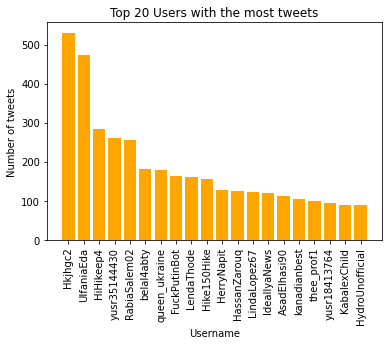

              username  followers
0        fyte_jeanette         85
1      MaksimR55305193          1
2            acwelling       8016
3        Arablebanese1        602
4             segar_21        342
...                ...        ...
30684    VigilantinfoN       5563
30685  MWilkin18743449         63
30686    RichardWalkus        105
30687      ericfranckx         59
30688     nikolay_bart        522

[30689 rows x 2 columns]


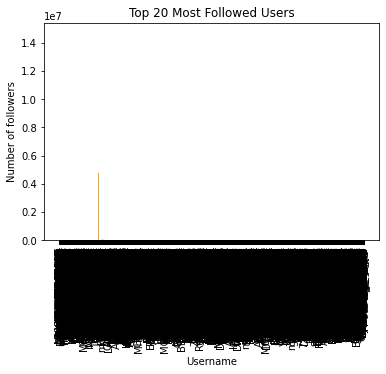

              username  avg(favorite_count)
7828            Tendar          1831.000000
2847         UAWeapons          1554.000000
8403   jensstoltenberg          1419.000000
2828            McFaul          1247.000000
1566     strategywoman          1201.727273
10063             NATO          1117.000000
8585    UAarmy_animals          1077.750000
6015   EuromaidanPress           877.500000
2981     officejjsmart           849.500000
1310      IuliiaMendel           670.000000
497     lesiavasylenko           650.000000
10060        DefenceHQ           596.500000
5869         Azovsouth           477.000000
873           nexta_tv           475.782609
8905       igornovikov           441.333333
3264   Militarylandnet           394.461538
9715    WarintheFuture           360.666667
4773        igorsushko           334.800000
3575     PeterTatchell           324.000000
518        NATO_AIRCOM           322.000000


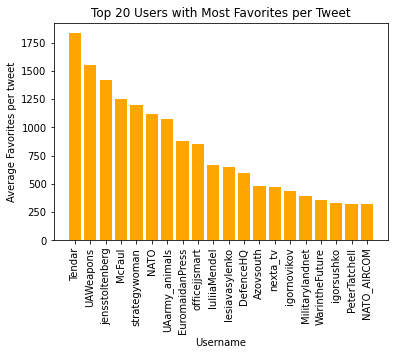

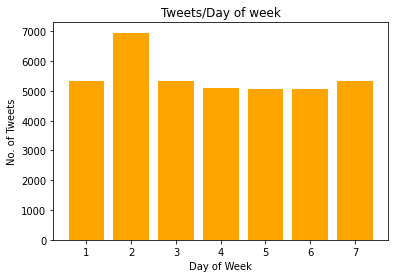

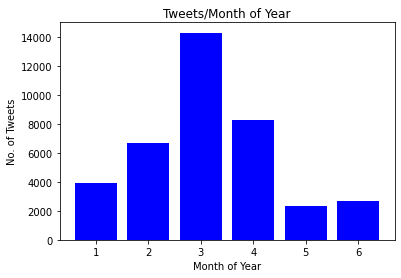

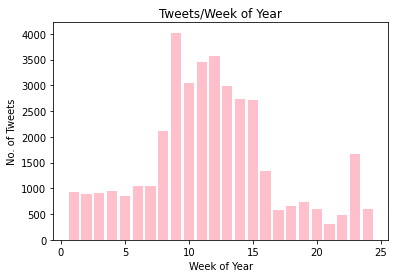

In [ ]:

# # Select a single column and sample and convert to pandas
# sample_df = df.select(['LISTPRICE']).sample(False, .5, 42)
# pandas_df = sample_df.toPandas()

# # Plot distribution of pandas_df and display plot
# sns.distplot(pandas_df)
# plt.show()

import seaborn as sns
import matplotlib.pyplot as plt


#Users with the most tweets
users_most_tweets = sdf.groupBy('username').count().toPandas().nlargest(20,'count')
print(users_most_tweets)
plt.bar(users_most_tweets['username'], users_most_tweets['count'], color ='orange')
plt.xlabel("Username")
plt.ylabel("Number of tweets")
plt.title("Top 20 Users with the most tweets")
plt.xticks(rotation=90)
plt.show()

#Users with the most followers
users_most_followers = sdf.select(['username',sdf.followers.cast("integer")]).distinct().toPandas()
print(users_most_followers)
plt.bar(users_most_followers['username'], users_most_followers['followers'], color ='orange')
plt.xlabel("Username")
plt.ylabel("Number of followers")
plt.title("Top 20 Most Followed Users")
plt.xticks(rotation=90)
plt.show()


#Users with the greatest favorites / tweet 
users_most_favorites = sdf.select(['username',sdf.favorite_count.cast("float")]).groupBy('username').avg('favorite_count').toPandas().nlargest(20,'avg(favorite_count)')
print(users_most_favorites)
plt.bar(users_most_favorites['username'], users_most_favorites['avg(favorite_count)'], color ='orange')
plt.xlabel("Username")
plt.ylabel("Average Favorites per tweet")
plt.title("Top 20 Users with Most Favorites per Tweet")
plt.xticks(rotation=90)
plt.show()

#Tweets/Day of week
tweets_weekday_df = sdf.groupBy('dayofweek').count().sort('dayofweek').toPandas()
plt.bar(tweets_weekday_df['dayofweek'], tweets_weekday_df['count'], color ='orange')
plt.xlabel("Day of Week")
plt.ylabel("No. of Tweets")
plt.title("Tweets/Day of week")
plt.show()

#Tweets/month
tweets_month_df = sdf.groupBy('month').count().sort('month').toPandas()
plt.bar(tweets_month_df['month'], tweets_month_df['count'], color ='blue')
plt.xlabel("Month of Year")
plt.ylabel("No. of Tweets")
plt.title("Tweets/Month of Year")
plt.show()

#Tweets/weekofyear
tweets_week_df = sdf.groupBy('weekofyear').count().sort('weekofyear').toPandas()
plt.bar(tweets_week_df['weekofyear'], tweets_week_df['count'], color ='pink')
plt.xlabel("Week of Year")
plt.ylabel("No. of Tweets")
plt.title("Tweets/Week of Year")
plt.show()




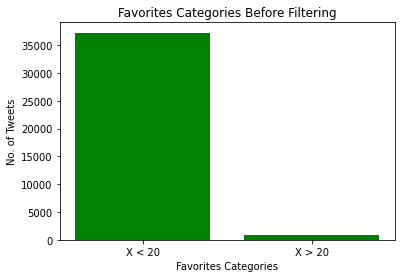

+-------+------------------+
|summary|    favorite_count|
+-------+------------------+
|  count|               298|
|   mean|367.98993288590606|
| stddev|390.47091042079427|
|    min|               101|
|    25%|             140.0|
|    50%|             231.0|
|    75%|             418.0|
|    max|               991|
+-------+------------------+



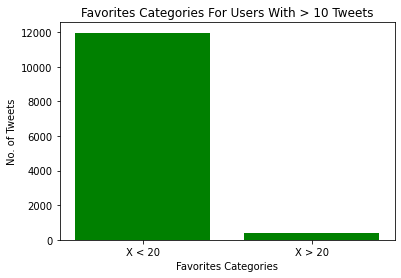

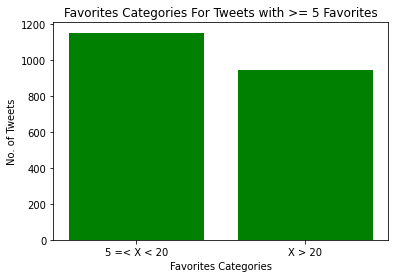

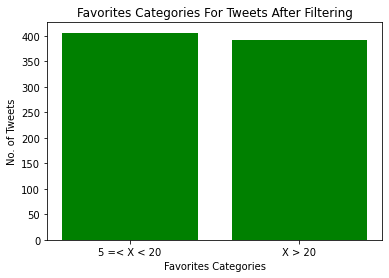

+--------------------+
|           char_only|
+--------------------+
|anitaanandmp conf...|
|⭕ 🇺🇦🇷🇺 ukrain...|
|🇸🇪🇺🇦 carl gus...|
|⚡ chinese foreign...|
|the kremlin said ...|
|🇵🇱 poland will ...|
|🕯️ glory to the ...|
|mfarussia muzeypo...|
|tineabarba youre ...|
|369dayofwar ⚡a ne...|
|sbu caught anothe...|
|the day began wit...|
|seems russia real...|
|here are todays c...|
|🇺🇦🦾 a year ago...|
|🇺🇦✨join us toda...|
|⚡ new round of mi...|
|🇹🇷turkey has st...|
|destroyed russian...|
|after images of p...|
+--------------------+
only showing top 20 rows

+--------------------+
|               words|
+--------------------+
|[anitaanandmp, co...|
|[⭕, 🇺🇦🇷🇺, ukr...|
|[🇸🇪🇺🇦, carl, ...|
|[⚡, chinese, fore...|
|[the, kremlin, sa...|
|[🇵🇱, poland, wi...|
|[🕯️, glory, to, ...|
|[mfarussia, muzey...|
|[tineabarba, your...|
|[369dayofwar, ⚡a,...|
|[sbu, caught, ano...|
|[the, day, began,...|
|[seems, russia, r...|
|[here, are, today...|
|[🇺🇦🦾, a, year,...|
|[🇺🇦✨join, us, t...|
|[⚡, new, round, o.

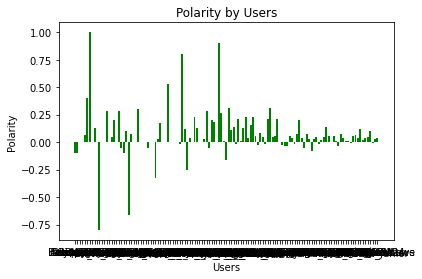

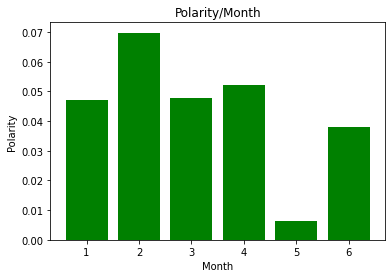

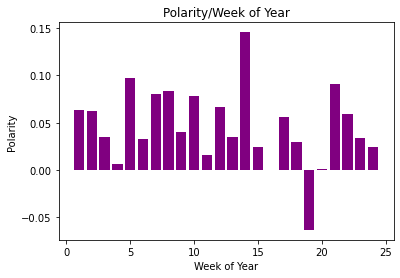

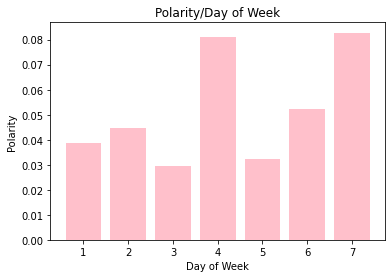

Row(favorite_category=0.0, features_text=SparseVector(40, {0: 0.8254, 2: 2.5898, 5: 1.6913, 6: 1.3788, 8: 0.9617, 10: 1.8363, 14: 3.8421, 15: 0.3883, 17: 0.5629, 18: 1.01, 19: 1.1188, 20: 1.2323, 21: 2.4592, 23: 1.6344, 24: 0.7917, 26: 1.455, 27: 2.3954, 28: 0.6575, 29: 1.6796, 30: 2.3238, 33: 1.2027, 34: 0.9245, 35: 1.2673, 37: 0.7726, 38: 1.3363, 39: 2.3561}), features_text=SparseVector(40, {0: 0.8254, 2: 2.5898, 5: 1.6913, 6: 1.3788, 8: 0.9617, 10: 1.8363, 14: 3.8421, 15: 0.3883, 17: 0.5629, 18: 1.01, 19: 1.1188, 20: 1.2323, 21: 2.4592, 23: 1.6344, 24: 0.7917, 26: 1.455, 27: 2.3954, 28: 0.6575, 29: 1.6796, 30: 2.3238, 33: 1.2027, 34: 0.9245, 35: 1.2673, 37: 0.7726, 38: 1.3363, 39: 2.3561}))
Row(favorite_category=0.0, features_text=SparseVector(40, {0: 1.6509, 3: 1.2771, 8: 0.4808, 9: 2.1287, 11: 1.3738, 15: 0.1294, 16: 0.8169, 17: 1.1258, 20: 2.4646, 21: 0.8197, 22: 1.0739, 23: 0.8172, 24: 1.5834, 26: 0.7275, 28: 0.6575, 29: 0.8398, 31: 0.9998, 36: 2.899, 37: 0.7726, 39: 1.178}), fe

In [ ]:


#Categorize the number of favorites
# sdf = sdf.withColumn('favorite_category', 
#                          sf.when(sdf.favorite_count < 10, 0) \
#                             .when(sdf.favorite_count < 100, 1) \
#                             .otherwise(2))
sdf = sdf.withColumn('favorite_category', 
                         sf.when(sdf.favorite_count < 20, 0.0) \
                            .otherwise(1.0))

# sdf.show(5, vertical=True)

#Visualize Favorites Categories Count Before Filtering
fav_cat_df = sdf.groupBy('favorite_category').count().sort('favorite_category').toPandas()
# plt.bar(['< 10', '< 100', '>= 100'], fav_cat_df['count'], color ='green')
plt.bar(['X < 20', 'X > 20'], fav_cat_df['count'], color ='green')

plt.xlabel("Favorites Categories")
plt.ylabel("No. of Tweets")
plt.title("Favorites Categories Before Filtering")
plt.show()

ml_df = sdf.select("username","tweetid","text","count","favorite_count",'favorite_category')
# distribution of tweets with favorites_count > 100

ml_df.filter(sdf.favorite_count > 100).select('favorite_count').summary().show()

#Visualize Tweets from accounts that have less than x tweets
ml_df = sdf.filter(sdf['count'] > 10)
fav_cat_df = ml_df.groupBy('favorite_category').count().sort('favorite_category').toPandas()
# plt.bar(['< 10', '< 100', '>= 100'], fav_cat_df['count'], color ='green')
plt.bar(['X < 20', 'X > 20'], fav_cat_df['count'], color ='green')

plt.xlabel("Favorites Categories")
plt.ylabel("No. of Tweets")
plt.title("Favorites Categories For Users With > 10 Tweets")
plt.show()

#Remove Tweets below a threshold of likes
greater_than_4 = sdf.filter(sdf.favorite_count > 4)

fav_cat_df = greater_than_4.groupBy('favorite_category').count().sort('favorite_category').toPandas()
# plt.bar(['5 <= x < 10', '< 100', '>= 100'], fav_cat_df['count'], color ='green')
plt.bar(['5 =< X < 20', 'X > 20'], fav_cat_df['count'], color ='green')
plt.xlabel("Favorites Categories")
plt.ylabel("No. of Tweets")
plt.title("Favorites Categories For Tweets with >= 5 Favorites")
plt.show()

#Remove Tweets below a threshold of likes from ml_df
ml_df = ml_df.filter(sdf.favorite_count > 4)

fav_cat_df = ml_df.groupBy('favorite_category').count().sort('favorite_category').toPandas()
#plt.bar(['5 <= x < 10', '< 100', '>= 100'], fav_cat_df['count'], color ='green')
plt.bar(['5 =< X < 20', 'X > 20'], fav_cat_df['count'], color ='green')

plt.xlabel("Favorites Categories")
plt.ylabel("No. of Tweets")
plt.title("Favorites Categories For Tweets After Filtering")
plt.show()

cleaner_udf = sf.udf(lambda txt: clean(
    txt, 
        fix_unicode=True,
        to_ascii=True, 
        lower=True,
        no_line_breaks=True,
        no_emails=True,
        no_phone_numbers=True,
        no_punct=True
))



#Clean the text
ml_df = ml_df.withColumn('char_only', cleaner_udf(col('text'))) 
ml_df.select('char_only').show()

#Tokenize text col
tokenizer = Tokenizer(inputCol="char_only", outputCol="words")
ml_df = tokenizer.transform(ml_df)
ml_df.select('words').show()

#Tokenize username to make it an array
tokenizer = Tokenizer(inputCol="username", outputCol="username_lst")
words_df = tokenizer.transform(ml_df)
words_df.select('username_lst').show()

#Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
words_df = remover.transform(words_df)

#Sentiment Analysis on text.
def get_sentiment(tweet):
    blob = TextBlob(tweet.char_only)
    return (tweet.tweetid, tweet.username, tweet.month, tweet.weekofyear, tweet.dayofweek, blob.sentiment.polarity)
#Measure polarity of each tweet
sentiment_df = words_df.rdd.map(lambda tweet: get_sentiment(tweet)).toDF(['tweetid','username','month','weekofyear','dayofweek', 'polarity'])
sentiment_df.show(5, vertical=True)

#Filters tweets for users with > 0 (reduced to zero so it works with one file) tweets (can be changed), then takes the sum of the polarity for each user and divides it by the number of tweets (normalizing)
user_sentiment_df = sentiment_df.groupby('username').agg(F.count('username').alias('count'),(F.sum('polarity') / F.count('username')).alias('polarity')).sort('count',asc=False).toPandas()

#Takes the sum of the polarity for each month and divides by the number of tweets that month (normalizing)
pol_month_df = sentiment_df.groupby('month').agg((F.sum('polarity') / F.count('month')).alias('polarity')).sort('month', asc=True).toPandas()
#Takes the sum of the polarity for week of the year and divides by the number of tweets that month (normalizing)
pol_week_df = sentiment_df.groupby('weekofyear').agg((F.sum('polarity') / F.count('weekofyear')).alias('polarity')).sort('weekofyear', asc=True).toPandas()
#Takes the sum of the polarity for the day of the week and divides by the number of tweets that month (normalizing)
pol_day_df = sentiment_df.groupby('dayofweek').agg((F.sum('polarity') / F.count('dayofweek')).alias('polarity')).sort('dayofweek', asc=True).toPandas()

#Visualize polarity
plt.bar(user_sentiment_df['username'], user_sentiment_df['polarity'], color ='green')
plt.xlabel("Users")
plt.ylabel("Polarity")
plt.title("Polarity by Users")
plt.show()


plt.bar(pol_month_df['month'], pol_month_df['polarity'], color ='green')
plt.xlabel("Month")
plt.ylabel("Polarity")
plt.title("Polarity/Month")
plt.show()

plt.bar(pol_week_df['weekofyear'], pol_week_df['polarity'], color ='purple')
plt.xlabel("Week of Year")
plt.ylabel("Polarity")
plt.title("Polarity/Week of Year")
plt.show()

plt.bar(pol_day_df['dayofweek'], pol_day_df['polarity'], color ='pink')
plt.xlabel("Day of Week")
plt.ylabel("Polarity")
plt.title("Polarity/Day of Week")
plt.show()

#Cleaning: Remove urls, punctiontion 
#Transform num of likes to categories, from 5 categories based on ranges

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=40)
featurized_df = hashingTF.transform(words_df)
idf = IDF(inputCol="rawFeatures", outputCol="features_text")
idf_model = idf.fit(featurized_df)
featurized_df = idf_model.transform(featurized_df)

featurized_df = featurized_df.withColumn("label",col('favorite_category'))


for features in featurized_df.select('favorite_category','features_text','features_text').take(3):
    print(features)

#UserID hashing
hashingTF = HashingTF(inputCol="username_lst", outputCol="rawFeatures_username", numFeatures=20)
featurized_df = hashingTF.transform(featurized_df)
idf = IDF(inputCol="rawFeatures_username", outputCol="features_username")
idf_model = idf.fit(featurized_df)
featurized_df = idf_model.transform(featurized_df)

for features in featurized_df.select('favorite_category','features_username','features_text').take(3):
    print(features)


from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# indexer = StringIndexer(inputCols=['username'], outputCols=['usernameIndex'])
# indexed_sdf = indexer.fit(sdf).transform(sdf)
# encoder = OneHotEncoder(inputCols=['usernameIndex'], outputCols=['usernameIndex'], dropLast=False)
# encoded_sdf = encoder.fit(indexed_sdf).transform(indexed_sdf)
# Assemble all of the vectors into one
assembler = VectorAssembler(inputCols=['features_username','features_text'],outputCol= "features")
featurized_df = assembler.transform(featurized_df)
featurized_df.select( ['features']).show (truncate=False)




#split for training and validation
train, validate = featurized_df.randomSplit([0.8, 0.2],seed = 97435)





In [ ]:
#Machine Learning Prediction Models

#NaiveBayes
nb = NaiveBayes(modelType="multinomial",labelCol="label", featuresCol="features")
#This is a model that needs to be saved
nbModel = nb.fit(train)
#Make Predictions
nb_predictions = nbModel.transform(validate)
nb_predictions.show(5, vertical=True, truncate=False)






-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 userid                  | 1026287958087876610                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
#Evaluate NaiveBayes
#Show confusion matrix
print("Confusion Matrix for NaiveBayes")
nb_predictions.groupby('label').pivot('prediction').count().sort('label').show()

confusion_matrix = nb_predictions.groupby('label').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(confusion_matrix):
    tn = confusion_matrix[0][1]  # True Negative
    fp = confusion_matrix[0][2]  # False Positive
    fn = confusion_matrix[1][1]  # False Negative
    tp = confusion_matrix[1][2]  # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print("Accuracy, Precision, Recall, F1 Score")
print(calculate_recall_precision(confusion_matrix))

evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(nb_predictions)
print("AUC: %g" % (auc))



Confusion Matrix for NaiveBayes
+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|  0.0| 54| 21|
|  1.0| 26| 55|
+-----+---+---+

Accuracy, Precision, Recall, F1 Score
(0.6987179487179487, 0.7236842105263158, 0.6790123456790124, 0.7006369426751592)
AUC: 0.560823


+---------------+-----+-------------------+
|       username|count|        probability|
+---------------+-----+-------------------+
|PolishRoyalGoat|    1| 0.9974621049423529|
|        RoINTEL|    1| 0.7189046990391151|
| UkraineEugenia|    1|0.02165005885170504|
|     DucuGavril|    1|  0.999999569296197|
|  imminent_news|    1| 0.9988880950621509|
|    MatreshkaRF|    1| 0.9987663698012175|
|   ukrainewar24|    1| 0.9990100305970688|
|    markito0171|    1| 0.7442653013198226|
|     W_W_3_2022|    1| 0.9422603367316988|
|  f_o_r_Ukraine|    1| 0.8142144995924803|
|         azexl2|    1|   0.87248339812051|
|  OccupySchagen|    1| 0.6878809804812244|
|       L_Team10|    1|0.07647374346470648|
|   aborealis940|    1| 0.3878455683814913|
|   Chronology22|    1| 0.9933273626359619|
|      skadefron|    1| 0.5879063938027876|
| PeterClifford1|    1|0.08447243557855895|
| warinukraineua|    1|0.00847626603527192|
|ManojKu40226010|    1| 0.9999993237085623|
|     M_R_TEMPEL|    1| 0.998031

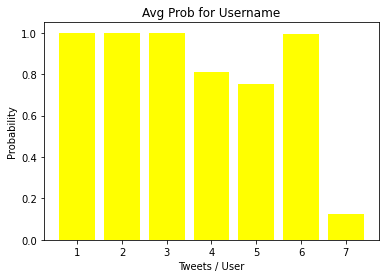

In [ ]:
from pyspark.ml.functions import vector_to_array

#Visualize prediction accuracy
#Probability again frequency of users tweets
prob_user_count_df = nb_predictions.groupby('username').agg(F.count('username').alias('count'), (F.sum(vector_to_array('probability')[0]) / F.count('username')).alias('probability')).sort('count')
prob_user_count_df.show()
prob_user_count_df = prob_user_count_df.toPandas()

plt.bar(prob_user_count_df['count'], prob_user_count_df['probability'], color ='yellow')

plt.xlabel("Tweets / User")
plt.ylabel("Probability")
plt.title("Avg Prob for Username")
plt.show()

prob_user_count_df = nb_predictions.groupby('username').agg(F.count('username').alias('count'), (F.sum(vector_to_array('probability')[0]) / F.count('username')).alias('probability')).sort('count')

# plt.hist(prob_user_count_df['count','probability'], color ='yellow')

# plt.xlabel("Tweets / User")
# plt.ylabel("Probability")
# plt.title("Avg Prob for Username")
# plt.show()



In [ ]:
#Logistic Regresssion Model
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
#This is a model that needs to be saved
lr_model = lr.fit(train)

print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)

lr_preds = lr_model.transform(validate)
lr_preds.select('tweetid','prediction','label').show(5)



Coefficients:  [-0.8472613050768136,-0.6535629774893749,0.06230713778408183,0.497095322267907,-0.5153071597652583,0.06296058646622647,-0.19687613506799817,0.125997174935872,0.4632966418140361,-0.0521073545421551,0.29293575518308146,-0.5149754285764554,0.025754031971758115,-0.2204244557435626,0.1367754828142046,0.6126228265308726,0.5607497761140766,-0.2317250312735899,-0.3020631359254106,-1.5495096409777618,-0.07975583013207758,0.059113892837556525,0.05174047910076,-0.22479156016704976,0.05228160541170753,-0.1086891471299088,-0.4053700151711429,-0.16711928551834782,0.5992848179722986,0.1118276234017964,0.031095032685479522,0.27343985049727193,-0.014463003945086341,-0.225556924529422,-0.12180995769443478,2.0193309675095197,-0.14995612440170963,-0.0401887222882024,-0.08936365325329104,-0.10140293440790175,0.09372174810181778,0.020809411080157787,-0.23935008608712458,-0.08730086978124815,-0.33732291869585895,-0.023408712922115296,0.006912637686384847,-0.23722145454236115,-0.050347103251178

+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|  0.0| 48| 27|
|  1.0| 26| 55|
+-----+---+---+

Logistic Regression Confusion Matrix
Accuracy, Precision, Recall, F1 Score
(0.6602564102564102, 0.6707317073170732, 0.6790123456790124, 0.6748466257668712)
AUC: 0.703539


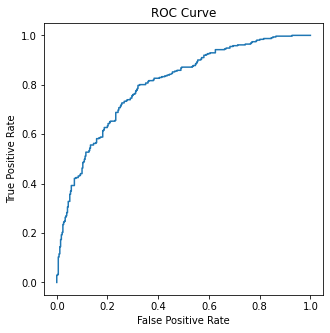

In [ ]:
#Evalute Logistic Regression
#Show confusion matrix
lr_preds.groupby('label').pivot('prediction').count().sort('label').show()

confusion_matrix = lr_preds.groupby('label').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(confusion_matrix):
    tn = confusion_matrix[0][1]  # True Negative
    fp = confusion_matrix[0][2]  # False Positive
    fn = confusion_matrix[1][1]  # False Negative
    tp = confusion_matrix[1][2]  # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print("Logistic Regression Confusion Matrix")
print("Accuracy, Precision, Recall, F1 Score")
print(calculate_recall_precision(confusion_matrix))

evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(lr_preds)
print("AUC: %g" % (auc))

#Plot ROC Curve
plt.figure(figsize=(5,5))
plt.plot(lr_model.summary.roc.select('FPR').collect(),
         lr_model.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.savefig("roc1.png")
plt.show()




In [ ]:
#Save models to the models folder
nbModel.write().overwrite().save('s3a://twitter-project-sl/models/nmModel')
lr_model.write().overwrite().save('s3a://twitter-project-sl/models/lr_model')

+---------------+-----+-------------------+
|       username|count|        probability|
+---------------+-----+-------------------+
|PolishRoyalGoat|    1| 0.9794145947117048|
|        RoINTEL|    1| 0.4998311610124171|
| UkraineEugenia|    1|0.07528602455306385|
|     DucuGavril|    1| 0.9977691508452319|
|  imminent_news|    1| 0.9145830273064779|
|    MatreshkaRF|    1| 0.9641556837489448|
|   ukrainewar24|    1| 0.9442931403141843|
|    markito0171|    1| 0.6058680235345464|
|     W_W_3_2022|    1| 0.6623187529907164|
|  f_o_r_Ukraine|    1| 0.8053960077198133|
|         azexl2|    1|  0.928049390842037|
|  OccupySchagen|    1| 0.7038119624168879|
|       L_Team10|    1|0.16918056185245717|
|   aborealis940|    1| 0.4226752934110856|
|   Chronology22|    1| 0.6311913120704044|
|      skadefron|    1|0.49113077960520624|
| PeterClifford1|    1|0.39298554710689343|
| warinukraineua|    1|0.15897988424560044|
|ManojKu40226010|    1| 0.9967883455891318|
|     M_R_TEMPEL|    1| 0.890791

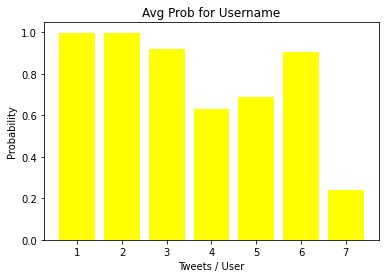

In [ ]:
#Visualize prediction accuracy
#Probability again frequency of users tweets
prob_user_count_df = lr_preds.groupby('username').agg(F.count('username').alias('count'), (F.sum(vector_to_array('probability')[0]) / F.count('username')).alias('probability')).sort('count')
prob_user_count_df.show()
prob_user_count_df = prob_user_count_df.toPandas()

plt.bar(prob_user_count_df['count'], prob_user_count_df['probability'], color ='yellow')

plt.xlabel("Tweets / User")
plt.ylabel("Probability")
plt.title("Avg Prob for Username")
plt.show()

prob_user_count_df = lr_preds.groupby('username').agg(F.count('username').alias('count'), (F.sum(vector_to_array('probability')[0]) / F.count('username')).alias('probability')).sort('count')


In [ ]:
#Visualiaz
